<a href="https://colab.research.google.com/github/sotainoue/ProbabilityNext/blob/master/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
!curl -L -o output.zip https://www.dropbox.com/sh/lk83x10ymajb39k/AAC8r42edgQQV5p5tLHKcwh7a?dl=0
!mkdir data
!unzip output.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  198k    0  198k    0     0  18050      0 --:--:--  0:00:11 --:--:-- 52901
Archive:  output.zip
mapname:  conversion of  failed
 extracting: data/state_event_13_order_03.csv  
 extracting: data/state_event_25_order_03.csv  
 extracting: data/state_event_31_order_07.csv  
 extracting: data/state_event_12_order_06.csv  
 extracting: data/state_event_34_order_05.csv  
 extracting: data/state_event_61_order_04.csv  
 extracting: data/state_event_14_order_05.csv  
 extracting: data/state_event_22_order_07.csv  
 extracting: data/state_event_25_order_05.csv  
 extracting: data/state_event_31_order_02.csv  
 extracting: data/state_event_35_order_07.csv  
 extracting: data/state_

In [0]:
events = []
for file in glob.glob("data/distance*.csv"):
    x = file.split("_")[2]
    if x not in events: 
        events.append(x) 
    
events.sort()


In [0]:

N = 9 # have to fix this for variable sized groups

X1 = []
X2 = []
Y = []

for e in events:
    
    states = np.zeros(N)
    
    
    for i in range(N):

        dist_file = "data/distance_event_" + e + "_order_0" + str(i+1) + ".csv"
        state_file = "data/state_event_" + e + "_order_0" + str(i+1) + ".csv"

        dist_data = np.genfromtxt(dist_file, delimiter=',')[1:,1:]
        state_data = np.genfromtxt(state_file, delimiter=',')[1:,1]

        dist_data2 = np.zeros((N,N))

        dist_data2[:dist_data.shape[0],:dist_data.shape[1]] = dist_data[:]
        
        j = np.nonzero(states-state_data)[0][0]

        depart = np.zeros(N)
        depart[j] = 1
        X1.append(states.copy())
        X2.append(dist_data2)
        Y.append(depart)
        states[j]=1

    
    
X1 = np.array(X1)
X2 = np.array(X2)
Y = np.array(Y)


In [24]:
X2.shape

(126, 9, 9)

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# order = np.load('drive/My Drive/orderings.npy')
# distances = np.load('drive/My Drive/distances.npy')
# social = np.load('drive/My Drive/social.npy')

In [0]:
# N = order.shape[0]
# iters = order.shape[1]

In [0]:
# X1 = []
# X2 = []
# Y = []

# for t in range(iters):
    
#     states = np.zeros(N)
    
    
#     for i in range(N):
#         j = int(order[i,t])
#         depart = np.zeros(N)
#         depart[j] = 1
#         X1.append(states.copy())
#         X2.append(distances[t])
#         Y.append(depart)
#         states[j]=1
        
    
    
# X1 = np.array(X1)
# X2 = np.array(X2)
# Y = np.array(Y)

In [0]:
states = tf.convert_to_tensor(X1)
states = tf.expand_dims(states,-1)
dists = tf.convert_to_tensor(X2)
labels = tf.convert_to_tensor(Y)


@tf.function
def calc_loss(in_w1, in_S, in_b):
    D = in_w1*tf.exp(-dists)

    S = (in_S)
    logits = tf.matmul(S,states) + tf.matmul(D,states)+in_b
    soft_denom = tf.reduce_sum(tf.where(states==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(states==0,tf.exp(logits) / soft_denom ,0)

    softmax = tf.squeeze(softmax)
    bb = labels * tf.math.log(softmax+ 1e-10)
    cross_entropy = -tf.reduce_sum(labels * tf.math.log(softmax + 1e-10), 1)

    loss = tf.reduce_mean(cross_entropy)
    return loss

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=1e-2)


In [0]:

S1 = tf.Variable(tf.random.normal(shape=(N,N ), dtype=tf.float64))
w1 = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float64))
b  = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float64))

loss_history=[]
weight_history=[]
b_history=[]
S_history=[]
def train_step():
    with tf.GradientTape() as tape:
    
        loss_value = calc_loss(w1,S1, b)

    
    loss_history.append(loss_value.numpy())
    weight_history.append(w1.numpy())
    S_history.append(S1.numpy())
    b_history.append(b.numpy())
    grads = tape.gradient(loss_value, [w1,S1, b])
    optimizer.apply_gradients(zip(grads, [w1,S1, b]))


In [0]:
for i in range(30000):
    train_step()

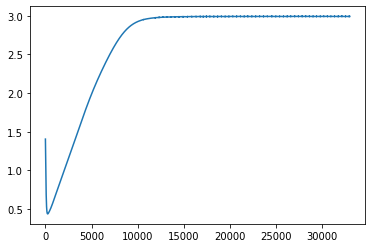

In [39]:
plt.plot(weight_history)

plt.show()

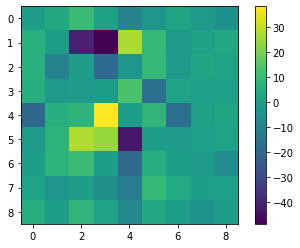

In [40]:
finalS = S_history[-1]
np.fill_diagonal(finalS,0)

plt.imshow(finalS)
plt.colorbar()
plt.show()


In [0]:
weight_history

In [44]:
weight_history[-1]

array([2.99048841])